# LightGBM graphs

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMRegressor
import shap
import effector
from PyALE import ale

style.use('seaborn-v0_8-ticks')
sns.set_theme(style="ticks")

def determine_unit(target):
    """Determine the unit based on the target variable."""
    return 'MASL' if 'GV' in target else 'L/s' if 'MB' in target else None

*Available targets = { 'h', 'GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18'}*

In [12]:
target = 'MB10'
unit = 'MASL' if 'GV' in target else 'L/s' if 'MB' in target else None

with open(f'plotting_data/LightGBM/LightGBM_{target}_plotting_data.pkl', 'rb') as f:
    plotting_data = pickle.load(f)

# Extract data for plotting
dates = plotting_data['dates']
y = plotting_data['y']
predictions = plotting_data['predictions']
split_index = plotting_data['split_index']
RMSE = plotting_data['RMSE']
MAE = plotting_data['MAE']
NSE = plotting_data['NSE']
KGE = plotting_data['KGE']

# Split according to train and test sets
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:] 
train_predictions = predictions[:split_index]
test_predictions = predictions[split_index:]
test_dates = dates.iloc[split_index:]

print("Data loaded")

Data loaded


<Figure size 640x480 with 0 Axes>

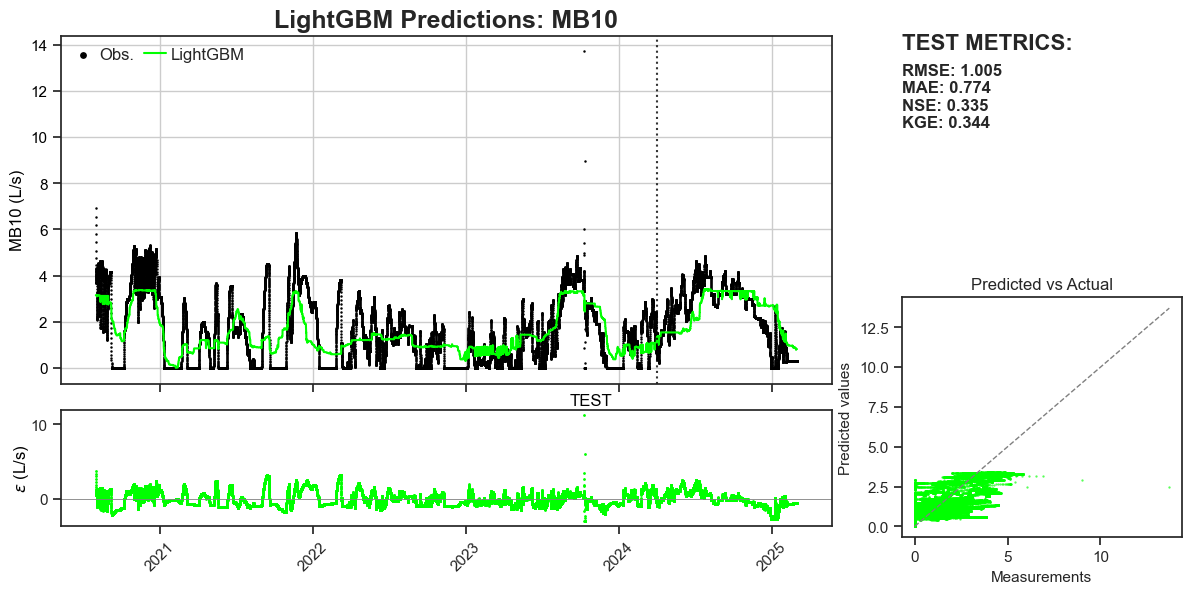

In [3]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
color_LightGBM = 'lime'

# Data and predictions
ax1.scatter(dates, y, color='black', s=0.6, label='Obs.')
# ax1.plot(dates, y, color='blue', linewidth=0.5, alpha=0.3)
ax1.plot(dates, predictions, color=color_LightGBM, linewidth=1.5, label='LightGBM')
ax1.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
fig.text(0.4125, 0.31, 'TEST', color='black')

ax1.set_ylabel(f'{target} ({unit})', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left', fontsize=12, ncols=2, markerscale=5, \
           columnspacing=0.6, handlelength=1.3, handletextpad=0.3, borderpad=0.2)
ax1.set_title(f'LightGBM Predictions: {target}', fontsize=18, fontweight='bold')
ax1.grid()

# Residuals
residuals = y - predictions
ax2.scatter(dates, residuals, color=color_LightGBM, s=1)
ax2.axhline(y=0, color='gray', linewidth=0.6, linestyle='-')
ax2.set_ylabel(rf'$\epsilon$ ({unit})', color='black', fontsize=12, labelpad=0)
# ax2.set_ylim(-4, 4)
# ax2.set_yticks(range(int(residuals.min()), int(residuals.max())+1, 4))
# ax2.tick_params(axis='y', labelcolor='purple')

# Formatting
plt.xticks(rotation=45)  
fig.tight_layout()  

# Text
fig.subplots_adjust(right=0.6)
title_text = "TEST METRICS:"
rmse_text = f'RMSE: {RMSE:.3f}'
mae_text = f'MAE: {MAE:.3f}'
NSE_text = f"NSE: {NSE:.3f}"
KGE_text = f"KGE: {KGE:.3f}"

metrics_text = '\n'.join([rmse_text, mae_text, NSE_text, KGE_text])
fig.text(0.65, 0.93, title_text, verticalalignment='top', fontweight='bold', fontsize=16)
fig.text(0.65, 0.88, metrics_text, verticalalignment='top', fontweight='bold', fontsize=12)

# Scatter plot for predicted vs measured values
ax3 = fig.add_axes([0.65, 0.09, 0.2, 0.4]) #type: ignore (Manually placed)

# Add a grey diagonal line from bottom-left to top-right
min_val = min(y.min(), predictions.min())
max_val = max(y.max(), predictions.max())
ax3.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=1)

# Plot
ax3.scatter(y, predictions, color=color_LightGBM, alpha=0.5, s=0.5, marker='D')
ax3.set_xlabel(f'Measurements', fontsize=11)
ax3.set_ylabel(f'Predicted values', fontsize=11)
ax3.set_title('Predicted vs Actual', fontsize=12)

plt.show()

# # Optimize quality by saving the plot with high DPI
# plt.savefig('high_quality_plot.png', dpi=300, bbox_inches='tight')

# # Alternatively, saving in vector format (SVG or PDF) to maintain quality on zoom
# plt.savefig('high_quality_plot_SVG.svg', dpi=300, bbox_inches='tight')

# XAI Visualization

In [2]:
import os
from pathlib import Path
root_dir = Path(os.getcwd()).resolve().parent
os.chdir(root_dir)
from utils.data_preparation import preprocess_data, split_data, mapping

In [198]:
target = 'GV51'

In [199]:
features = ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18',
            'h', 'h_MA_007', 'h_MA_014', 'h_MA_030', 'h_MA_060', 'h_RC_007', 'h_RC_030',
            'P', 'P_RS_007', 'P_RS_030', 'P_RS_060', 'P_RS_090', 'P_RS_180',
            'TA', 'TA_MA_001', 'TA_MA_007', 'TA_MA_030', 'TA_MA_060',
            'TW', 'TW_MA_007', 'TW_MA_030',
            'Q', 'Q_RS_007', 'Q_RS_030',
            't', 'ln_t', 'Cos_s', 'Sin_s', 'Cos_2s', 'Sin_2s', 'month', 'year']

test_size = 0.2
poly_degree = 0

if target in features:
    features.remove(target)
path = f'./data/LOS_DAMM_{mapping(target)}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])

# Extract start and end dates
dates = data['Date-Time']
start_date = dates.iloc[0].date()  # First date (YYYY-MM-DD)
end_date = dates.iloc[-1].date()  # Last date (YYYY-MM-DD)

# Preprocess the data (You would need to define preprocess_data elsewhere in your code)
X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, test_size=test_size)

# Split the data into training and testing sets (Assumes split_data is defined elsewhere)
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)

# Concatenate training and test data for full data (if needed)
X_all = pd.concat([X_train, X_test])

print("data loaded")

with open(f'./visualization/models/LightGBM/LightGBM_model_{target}.pkl', 'rb') as f:
    LGBM_model = pickle.load(f)

print(f"{target} LGBM_model loaded")

data loaded
GV51 LGBM_model loaded


In [200]:
LGBM_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.23675946687261856,
              learning_rate=0.012317007662289907, linear_tree=False,
              max_depth=2, min_child_samples=24,
              min_split_gain=2.623162262656614e-07, n_estimators=2033,
              num_leaves=14, reg_alpha=84.52772218004151,
              reg_lambda=0.0012908907617712017, subsample=0.4096758922784775,
              verbose=-1)

In [201]:
train_predictions = LGBM_model.predict(X_train)
test_predictions = LGBM_model.predict(X_test)
all_predictions = LGBM_model.predict(X_all)

In [202]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from processing.custom_metrics import nash_sutcliffe, kling_gupta
rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mae_test = mean_absolute_error(y_test, test_predictions)
NSE_test = nash_sutcliffe(y_test, test_predictions)
KGE_test = kling_gupta(y_test, test_predictions)

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)
print("NSE Test:", NSE_test)
print("KGE Test:", KGE_test)

RMSE Train: 0.1374516184871629
RMSE Test: 0.3589059853810114
MAE Test: 0.2819261701786086
NSE Test: 0.9928158139342749
KGE Test: 0.9798967645096932


# ALE

## ALE WITH PACKAGE: *EFFECTOR*

In [18]:
def predict(x):
    return np.array(LGBM_model.predict(x))

In [48]:
print(X_test)

          Sin_s     Cos_s    Sin_2s    Cos_2s     t      ln_t  month  year  \
32122  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32123  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32124  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32125  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32126  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
...         ...       ...       ...       ...   ...       ...    ...   ...   
40148  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40149  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40150  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40151  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40152  0.858764  0.512371  0.880012 -0.474951  1674  7.422971      3  2025   

             h     GV1  ...  TA_MA_060  TW_MA_007  TW_MA_030   

In [19]:
X_test_numpy = X_test.values
print(X_test_numpy)

[[9.99990740e-01 4.30353830e-03 8.60699689e-03 ... 1.88870000e+03
  1.88870000e+03 1.88870000e+03]
 [9.99990740e-01 4.30353830e-03 8.60699689e-03 ... 1.90522000e+03
  3.79392000e+03 3.79392000e+03]
 [9.99990740e-01 4.30353830e-03 8.60699689e-03 ... 1.92174000e+03
  5.71566000e+03 5.71566000e+03]
 ...
 [8.49817092e-01 5.27077709e-01 8.95839291e-01 ... 6.67500000e+02
  1.09301100e+05 3.12882090e+05]
 [8.49817092e-01 5.27077709e-01 8.95839291e-01 ... 6.65250000e+02
  1.09706520e+05 3.13038800e+05]
 [8.58763958e-01 5.12371412e-01 8.80012204e-01 ... 6.63000000e+02
  1.10109520e+05 3.13193800e+05]]


In [40]:
print(target)

MB10


In [20]:
y_pred = LGBM_model.predict(X_test)
print(y_pred)

[548.19247922 548.18961254 548.18672405 ... 550.65868521 550.65008382
 550.64901797]


In [67]:
PDP = effector.PDP(data=X_test_numpy, model=predict)

In [21]:
ALE = effector.ALE(data=X_test_numpy, model=predict, feature_names=np.array(X_test.columns), target_name=np.array(target))


In [1]:
print(X_test.columns)

NameError: name 'X_test' is not defined

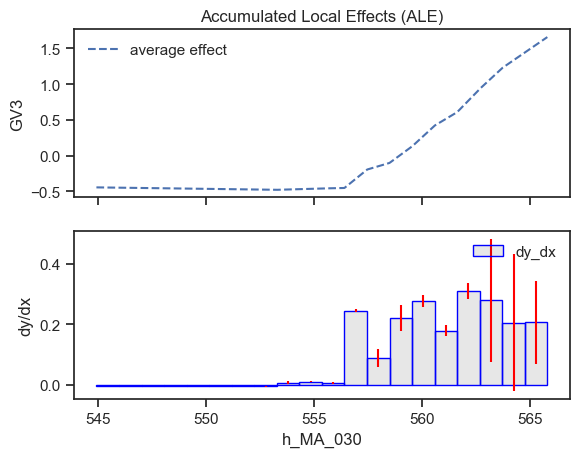

In [29]:
ALE.plot(17, heterogeneity=True)

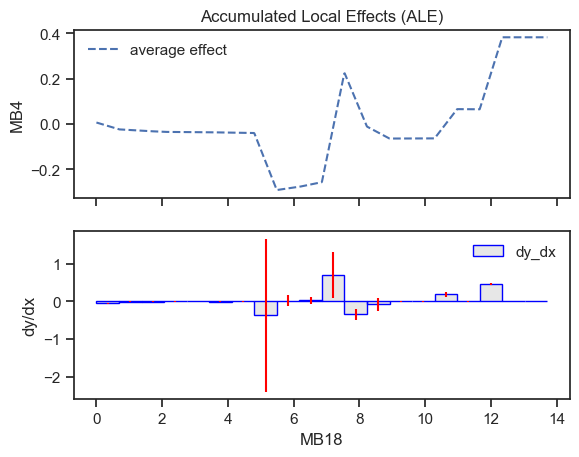

In [31]:
ALE.plot(15, heterogeneity=True)

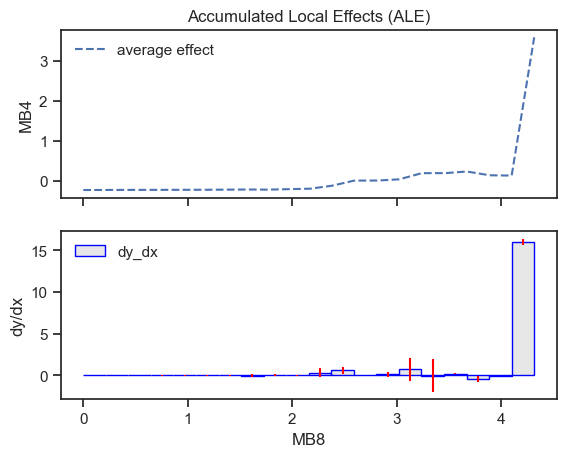

In [29]:
ALE.plot(13, heterogeneity=True)

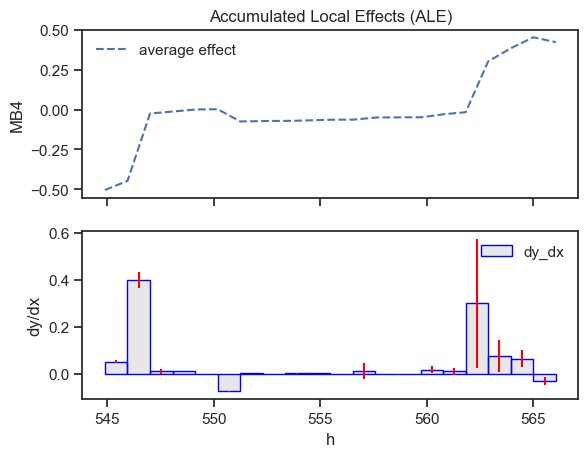

In [25]:
ALE.plot(8, heterogeneity=True) 

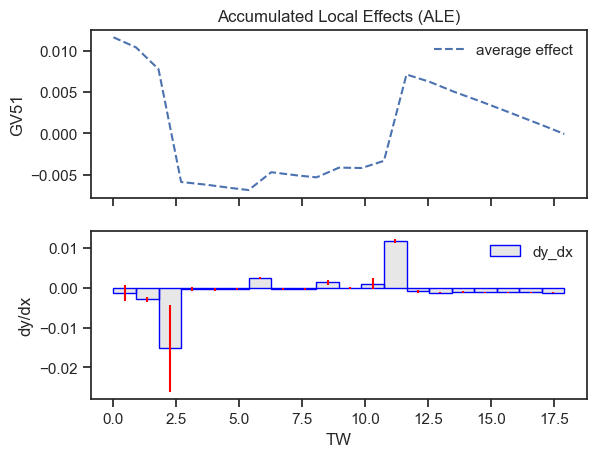

In [324]:
ALE.plot(19, heterogeneity=True) 

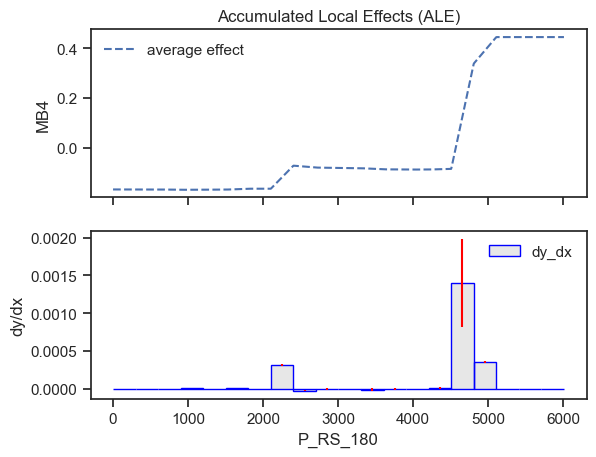

In [41]:
ALE.plot(38, heterogeneity=True) 

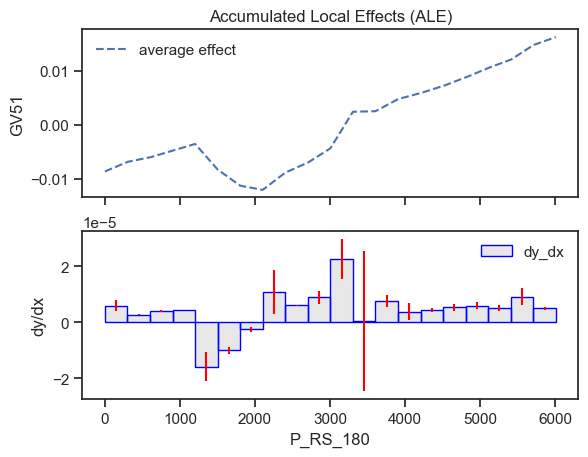

In [270]:
ALE.plot(38, heterogeneity=True) 

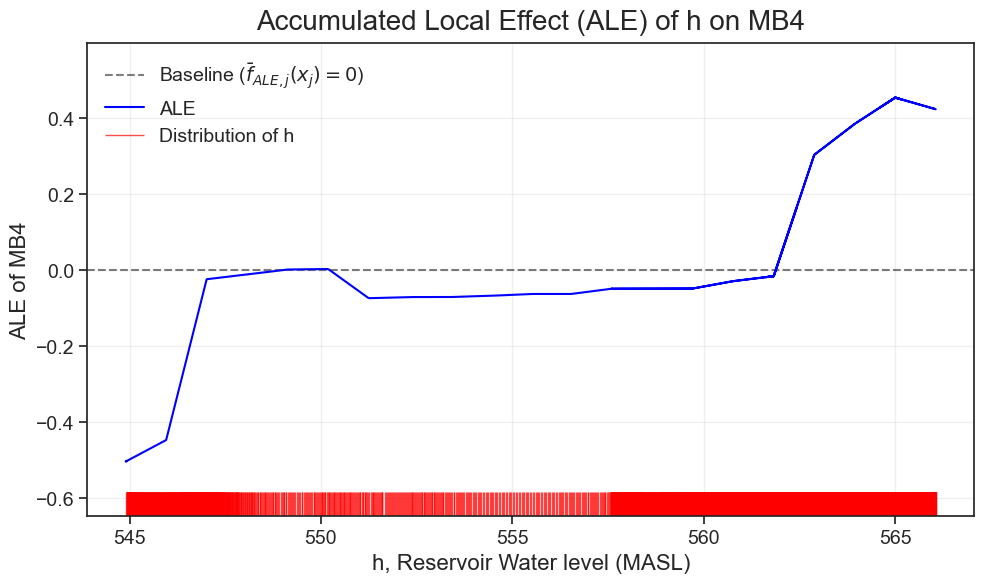

In [ ]:
xs_h = X_test['h'].to_numpy()

y_GV51_vs_h_ALE = ALE.eval(8, xs=xs_h)

xs_values = pd.Series(xs_h.flatten())
y_ALE_values = y_GV51_vs_h_ALE.flatten()
y_ALE_series = pd.Series(y_ALE_values)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label=r'Baseline ($\bar{f}_{ALE,j}(x_j) = 0$)')

# Create your original scatter plot on the axis
ax.plot(xs_values, y_ALE_values, label='ALE', color='blue')

# Add rugplot on the x-axis
sns.rugplot(x=xs_values, ax=ax, color='red', height=0.05, alpha=0.7, label='Distribution of h')

# Add title and legend
plt.title(f"Accumulated Local Effect (ALE) of h on {target}", fontsize=20, pad=10)
plt.xlabel("h, Reservoir Water level (MASL)", fontsize=16)
plt.ylabel(f"ALE of {target}", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.grid(alpha=.3)

# Optional: customize axes if needed
ax.set_xlim(min(xs_values)-1, max(xs_values)+1)
# ax.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()

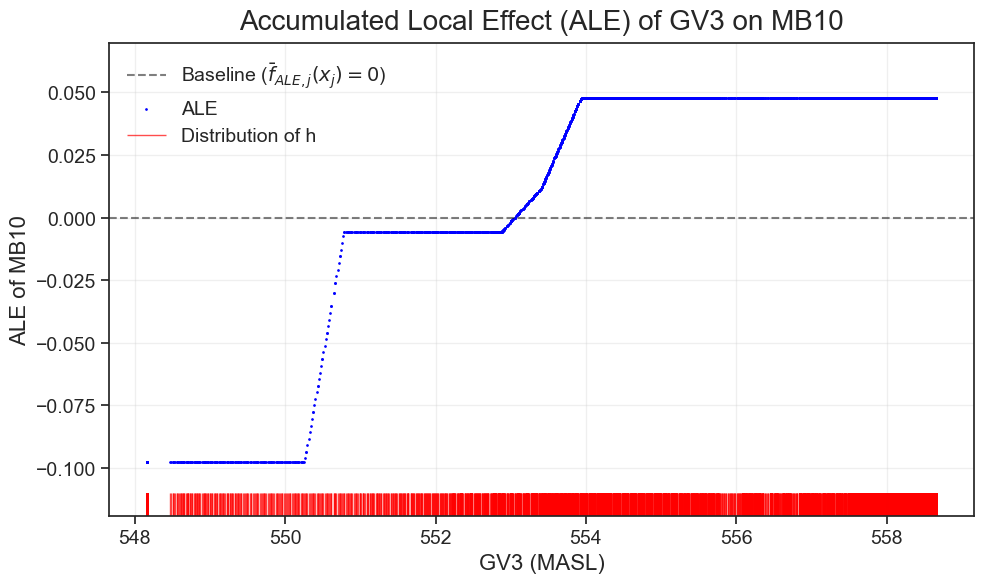

In [74]:
n = 11
x_variable = X_test.columns[n]
xs = X_test[x_variable].to_numpy()
y_ALE= ALE.eval(n, xs=xs)

xs_values = pd.Series(xs.flatten())
y_ALE_values = y_ALE.flatten()
y_ALE_series = pd.Series(y_ALE_values)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label=r'Baseline ($\bar{f}_{ALE,j}(x_j) = 0$)')

# Create your original scatter plot on the axis
ax.scatter(xs_values, y_ALE_values, label='ALE', color='blue', s=.9)

# # Add rugplot on the x-axis
sns.rugplot(x=xs_values, ax=ax, color='red', height=0.05, alpha=0.7, label='Distribution of h')

# Add title and legend
plt.title(f"Accumulated Local Effect (ALE) of {x_variable} on {target}", fontsize=20, pad=10)
plt.xlabel(f"{x_variable} ({determine_unit(x_variable)})", fontsize=16)
plt.ylabel(f"ALE of {target}", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.grid(alpha=.3)

# Optional: customize axes if needed
ax.set_xlim(min(xs_values)-.5, max(xs_values)+.5)
# ax.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()

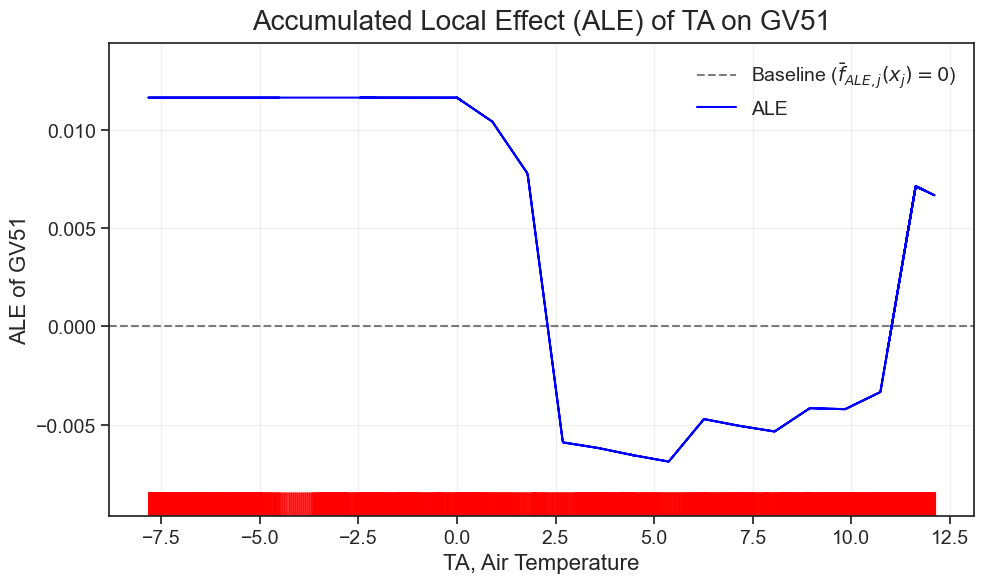

In [301]:
xs_TA = X_test['TA'].to_numpy()

y_GV51_vs_TW_ALE = ALE.eval(19, xs=xs_TA)

xs_values = pd.Series(xs_TA.flatten())
y_ALE_values = y_GV51_vs_TW_ALE.flatten()
y_ALE_series = pd.Series(y_ALE_values)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label=r'Baseline ($\bar{f}_{ALE,j}(x_j) = 0$)')

# Create your original scatter plot on the axis
ax.plot(xs_values, y_ALE_values, label='ALE', color='blue')

# Add rugplot on the x-axis
sns.rugplot(x=xs_values, ax=ax, color='red', height=0.05, alpha=0.7)

# Add title and legend
plt.title(f"Accumulated Local Effect (ALE) of TA on {target}", fontsize=20, pad=10)
plt.xlabel("TA, Air Temperature", fontsize=16)
plt.ylabel(f"ALE of {target}", fontsize=16)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 

plt.legend(fontsize=14)
plt.grid(alpha=.3)

# Optional: customize axes if needed
ax.set_xlim(min(xs_values)-1, max(xs_values)+1)
# ax.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()

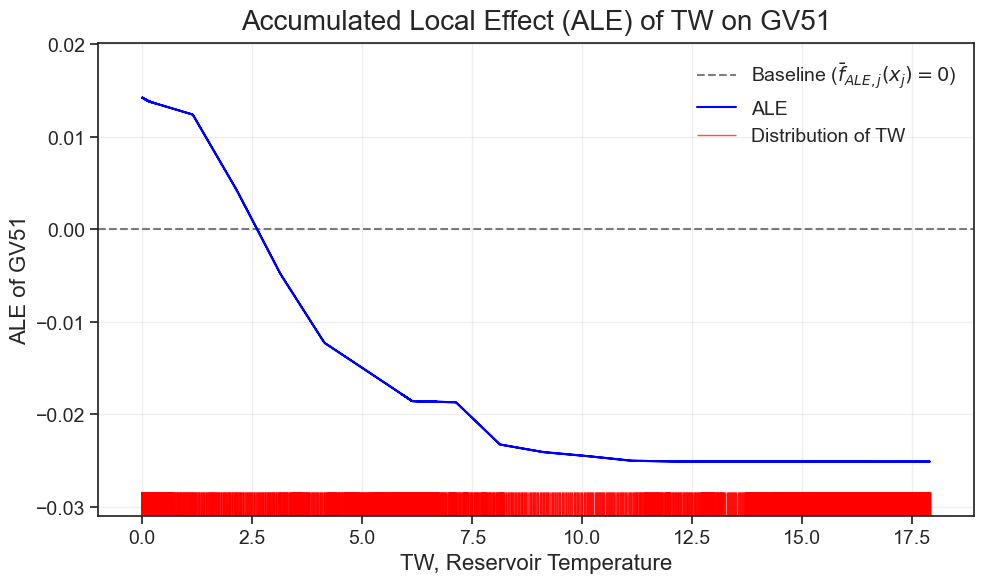

In [299]:
xs_TW = X_test['TW'].to_numpy()

y_GV51_vs_TA_ALE = ALE.eval(17, xs=xs_TW)

xs_values = pd.Series(xs_TW.flatten())
y_ALE_values = y_GV51_vs_TA_ALE.flatten()
y_ALE_series = pd.Series(y_ALE_values)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label=r'Baseline ($\bar{f}_{ALE,j}(x_j) = 0$)')

# Create your original scatter plot on the axis
ax.plot(xs_values, y_ALE_values, label='ALE', color='blue')

# Add rugplot on the x-axis
sns.rugplot(x=xs_values, ax=ax, color='red', height=0.05, alpha=0.7, label='Distribution of TW')

# Add title and legend
plt.title(f"Accumulated Local Effect (ALE) of TW on {target}", fontsize=20, pad=10)
plt.xlabel("TW, Reservoir Temperature", fontsize=16)
plt.ylabel(f"ALE of {target}", fontsize=16)
plt.xticks(fontsize=14)  # Increase the font size of x ticks
plt.yticks(fontsize=14)  # Increase the font size of y ticks

plt.legend(fontsize=14)
plt.grid(alpha=.3)

# Optional: customize axes if needed
ax.set_xlim(min(xs_values)-1, max(xs_values)+1)
# ax.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()

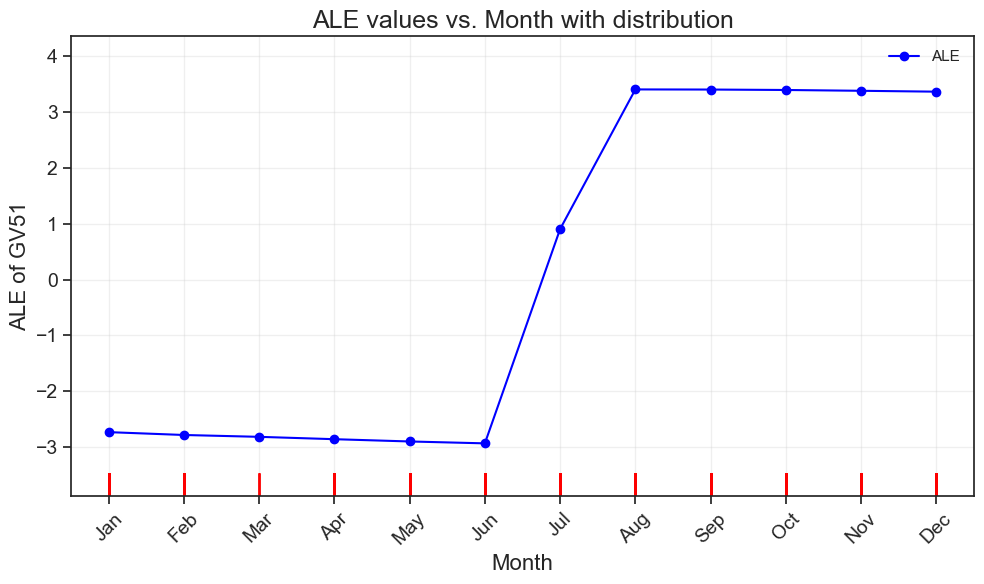

In [ ]:
# First group by month and calculate mean ALE values for each month
grouped_data = pd.DataFrame({'month': xs_values, 'ALE': y_ALE_values})
monthly_means = grouped_data.groupby('month').mean().reset_index()


# Sort by month to ensure proper order
monthly_means = monthly_means.sort_values('month')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a line plot with the grouped data
ax.plot(monthly_means['month'], monthly_means['ALE'], label='ALE', color='blue', marker='o')

# Add rugplot on the x-axis
sns.rugplot(x=xs_values, ax=ax, color='red', height=0.05, alpha=0.7)

# Add title and legend
plt.title("ALE values vs. Month with distribution", fontsize=18)
plt.xlabel("Month", fontsize=16)
plt.ylabel(f"ALE of {target}", fontsize=16)
plt.xticks(range(1, 13), fontsize=14)  # Set ticks for all 12 months
plt.yticks(fontsize=14)

plt.legend()
plt.grid(alpha=.3)

# Set proper x-axis limits
ax.set_xlim(0.5, 12.5)  # From just before 1 to just after 12

# After creating your figure and plot

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set x-ticks at each month position (1-12) and label with month names
plt.xticks(range(1, 13), month_names, fontsize=14, rotation=45)

# Rest of your code...

plt.tight_layout()
plt.show()

In [ ]:
# Investigate later
r_ale = effector.RegionalALE(data=X_test_numpy, model=predict, feature_names=np.array(X_test.columns), target_name=np.array(target))

## ALE WITH PACKAGE: *PyALE*

In [325]:
from PyALE import ale

PyALE._ALE_generic:INFO: Continuous feature detected.


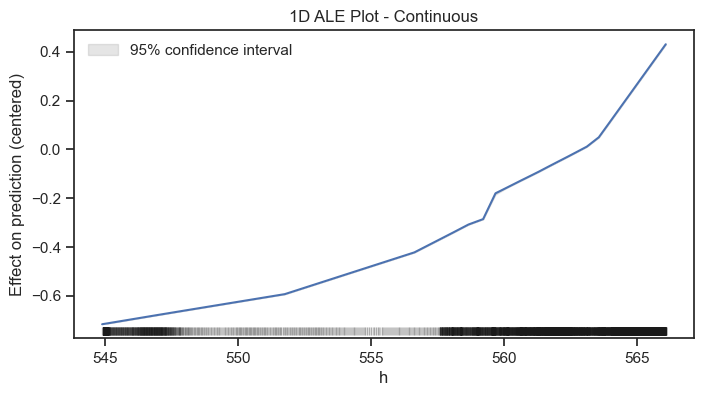

In [343]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X_test, model=LGBM_model, feature=["h"], grid_size=50, include_CI=True, C=0.95
)

PyALE._ALE_generic:INFO: Continuous feature detected.


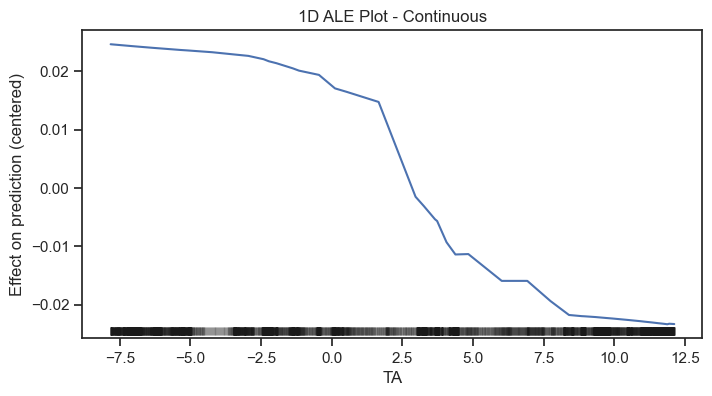

In [328]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X_test, model=LGBM_model, feature=["TA"], grid_size=50, include_CI=False
)

PyALE._ALE_generic:INFO: Continuous feature detected.


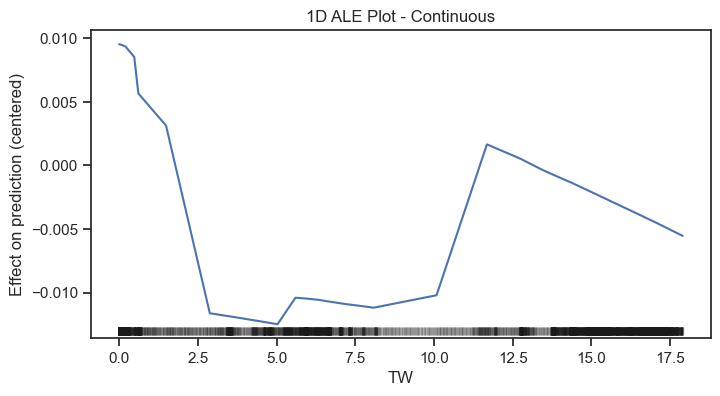

In [329]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X_test, model=LGBM_model, feature=["TW"], grid_size=50, include_CI=False
)

PyALE._ALE_generic:INFO: Discrete feature detected.


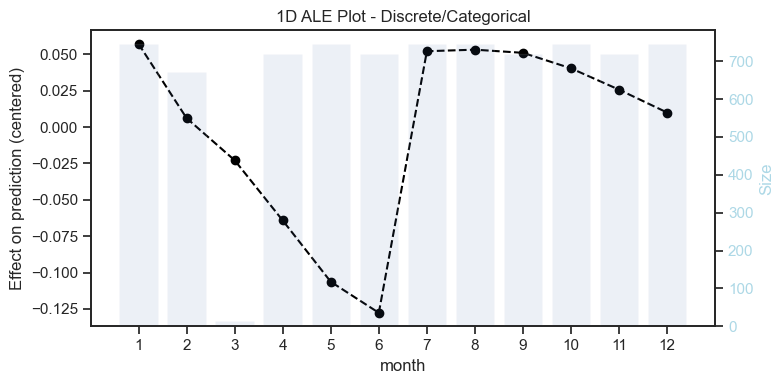

In [330]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X_test, model=LGBM_model, feature=["month"], grid_size=50, include_CI=False
)

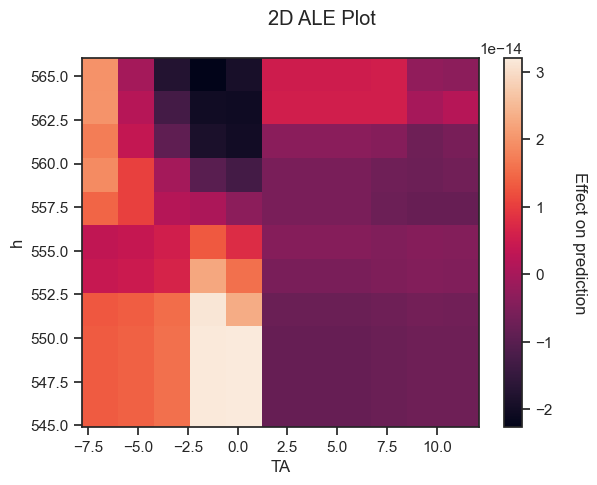

In [31]:
ale_eff = ale(X=X_test, model=LGBM_model, feature=["h", "TA"], grid_size=10)

# SHAP ANALYSIS

In [507]:
def create_yearly_comparison(X_all, dates, target_column):
    """
    Create a DataFrame with yearly data for seasonal comparison,
    and return dates for each year. Non-leap years will have NaN values for Feb 29.
    
    Parameters:
    -----------
    X_all : pandas.DataFrame
        DataFrame containing the features, including the target column
    dates : pandas.Series
        Series of datetime values, same length as X_all
    target_column : str
        Name of the column in X_all to analyze (e.g., 'X1')
        
    Returns:
    --------
    tuple
        (yearly_data, year_dates)
        - yearly_data: DataFrame with separate columns for each year,
          with indices representing the same point in time within each year
        - year_dates: Dictionary with years as keys and corresponding dates as values
    """
    import pandas as pd
    
    # Create a DataFrame that combines dates and target values
    df = pd.DataFrame({
        'datetime': dates,
        'target': X_all[target_column]
    })
    
    # Extract components needed for seasonal grouping
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    # Instead of using dayofyear, create a custom seasonal day that accounts for leap years
    # Create a standard date to align all years (using month, day, hour)
    # Use a leap year (2020) as reference for creating a standard date series
    df['ref_date'] = pd.to_datetime(
        '2020-' + df['month'].astype(str) + '-' + df['day'].astype(str) + ' ' + df['hour'].astype(str) + ':00:00'
    )
    
    # Extract the day of year from this reference date (all based on leap year)
    df['season_day'] = df['ref_date'].dt.dayofyear + df['hour']/24
    
    # Create a dictionary to store dates for each year
    year_dates = {}
    for year in df['year'].unique():
        year_dates[year] = df.loc[df['year'] == year, 'datetime'].values
    
    # Pivot the data to have separate columns for each year
    yearly_data = df.pivot_table(
        index=['season_day'],  # Use season_day for continuous representation
        columns='year',
        values='target',
        aggfunc='mean'  # In case there are duplicates
    ).reset_index()
    
    # Rename columns
    yearly_data.columns.name = None
    
    # Create proper time components from season_day
    # First, get the integer part (days)
    days = yearly_data['season_day'].astype(int)
    
    # Then, get the fractional part converted to hours (0-23)
    fractional_day = yearly_data['season_day'] - days
    hours = (fractional_day * 24).round().astype(int)
    
    # Handle edge case where hours == 24
    days = days + (hours == 24).astype(int)
    hours = hours % 24
    
    # Create a reference date (Jan 1 of a leap year) and add the days
    base_date = pd.to_datetime('2020-01-01') + pd.to_timedelta(days - 1, unit='D')
    
    yearly_data['month'] = base_date.dt.month
    yearly_data['day'] = base_date.dt.day
    yearly_data['week'] = base_date.dt.isocalendar().week
    yearly_data['hour'] = hours

    # Add quarter (1-4) based on month
    yearly_data['quarter'] = ((yearly_data['month'] - 1) // 3) + 1
    
    return yearly_data, year_dates

In [33]:
print(X_all)

          Sin_s     Cos_s    Sin_2s    Cos_2s     t      ln_t  month  year  \
0     -0.516062 -0.856551  0.884068  0.467359     1  0.000000      8  2020   
1     -0.516062 -0.856551  0.884068  0.467359     1  0.000000      8  2020   
2     -0.516062 -0.856551  0.884068  0.467359     1  0.000000      8  2020   
3     -0.516062 -0.856551  0.884068  0.467359     1  0.000000      8  2020   
4     -0.516062 -0.856551  0.884068  0.467359     1  0.000000      8  2020   
...         ...       ...       ...       ...   ...       ...    ...   ...   
40148  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40149  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40150  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40151  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40152  0.858764  0.512371  0.880012 -0.474951  1674  7.422971      3  2025   

          GV1     GV51  ...  TA_MA_001  TA_MA_007  TA_MA_030  T

In [508]:
yearly_h, yearly_dates = create_yearly_comparison(X_all, dates, 'h')

In [132]:
yearly_h

,season_day,2020,2021,2022,2023,2024,2025,month,day,week,hour,quarter
0,1.000000,NaN,560.89,558.82,553.260,559.624,563.848,1,1,1,0,1
1,1.041667,NaN,560.89,558.82,553.260,559.624,563.838,1,1,1,1,1
2,1.083333,NaN,560.88,558.82,553.260,559.624,563.838,1,1,1,2,1
3,1.125000,NaN,560.87,558.83,553.260,559.624,563.828,1,1,1,3,1
4,1.166667,NaN,560.87,558.83,553.260,559.624,563.828,1,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,366.791667,560.92,558.82,553.25,559.624,563.860,NaN,12,31,53,19,4
8780,366.833333,560.92,558.82,553.26,559.624,563.860,NaN,12,31,53,20,4
8781,366.875000,560.91,558.82,553.26,559.624,563.860,NaN,12,31,53,21,4
8782,366.916667,560.90,558.82,553.25,559.624,563.848,NaN,12,31,53,22,4


In [85]:
yearly_dates

{2020: array(['2020-08-01T00:00:00.000000000', '2020-08-01T01:00:00.000000000',
        '2020-08-01T02:00:00.000000000', ...,
        '2020-12-31T21:00:00.000000000', '2020-12-31T22:00:00.000000000',
        '2020-12-31T23:00:00.000000000'], dtype='datetime64[ns]'),
 2021: array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
        '2021-01-01T02:00:00.000000000', ...,
        '2021-12-31T21:00:00.000000000', '2021-12-31T22:00:00.000000000',
        '2021-12-31T23:00:00.000000000'], dtype='datetime64[ns]'),
 2022: array(['2022-01-01T00:00:00.000000000', '2022-01-01T01:00:00.000000000',
        '2022-01-01T02:00:00.000000000', ...,
        '2022-12-31T21:00:00.000000000', '2022-12-31T22:00:00.000000000',
        '2022-12-31T23:00:00.000000000'], dtype='datetime64[ns]'),
 2023: array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
        '2023-01-01T02:00:00.000000000', ...,
        '2023-12-31T21:00:00.000000000', '2023-12-31T22:00:00.000000000',

In [184]:
non_nan_count = yearly_h[2020].count()

It's crucial to remember that the dataset begins from 01/08/2020, and that there is a leap year in 2024. This makes the code need to adapt to these discrepancies when plotting and manipulating data etc.

In [ ]:
month_number = 2  # Change this to the month of interest
monthly_data = yearly_h[yearly_h['month'] == month_number]
monthly_data 

,season_day,2020,2021,2022,2023,2024,2025,month,day,week,hour,quarter
744,32.000000,NaN,555.81,556.43,552.30,555.902,560.594,2,1,5,0,1
745,32.041667,NaN,555.79,556.42,552.29,555.902,560.594,2,1,5,1,1
746,32.083333,NaN,555.79,556.42,552.28,555.902,560.604,2,1,5,2,1
747,32.125000,NaN,555.78,556.41,552.27,555.902,560.604,2,1,5,3,1
748,32.166667,NaN,555.78,556.40,552.27,555.914,560.604,2,1,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,60.791667,NaN,NaN,NaN,NaN,552.096,NaN,2,29,9,19,1
1436,60.833333,NaN,NaN,NaN,NaN,552.096,NaN,2,29,9,20,1
1437,60.875000,NaN,NaN,NaN,NaN,552.086,NaN,2,29,9,21,1
1438,60.916667,NaN,NaN,NaN,NaN,552.076,NaN,2,29,9,22,1


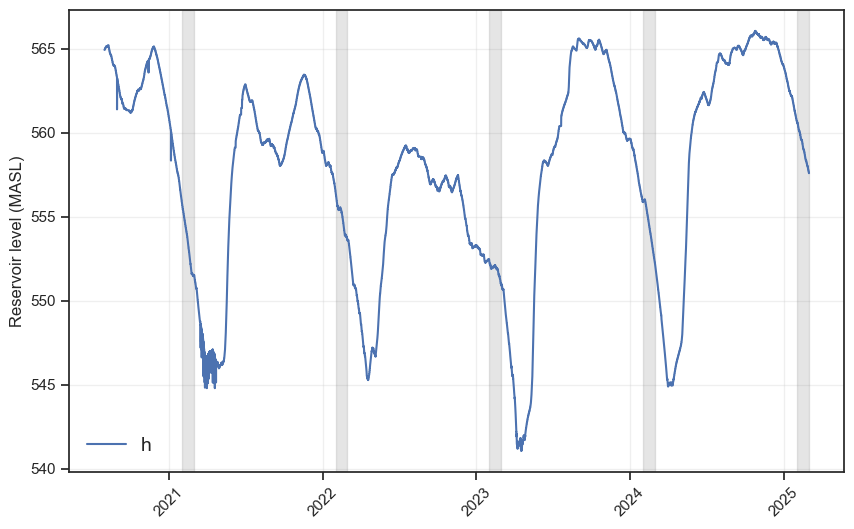

In [157]:
# Plotting all water levels data
plt.figure(figsize=(10, 6))

# Plot your main data
plt.plot(dates, X_all['h'], label='h')

# Define the month you want to highlight
month_to_highlight = 2  # February

# Create one span per year using the yearly_dates dictionary
for year, year_dates_array in yearly_dates.items():
    # Convert to pandas datetime if needed
    year_dates = pd.DatetimeIndex(year_dates_array)
    
    # Find all dates in this year that match the target month
    month_dates = year_dates[year_dates.month == month_to_highlight]
    
    # Only create a span if we have dates for this month in this year
    if len(month_dates) > 0:
        # Get the first and last date for this month
        start_date = month_dates[0]
        end_date = month_dates[-1]
        
        # Create a single span for the whole month
        plt.axvspan(start_date, end_date, alpha=0.2, color='gray')

plt.tick_params(axis='x', rotation=45)
plt.ylabel('Reservoir level (MASL)')
plt.legend(loc='lower left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 640x480 with 0 Axes>

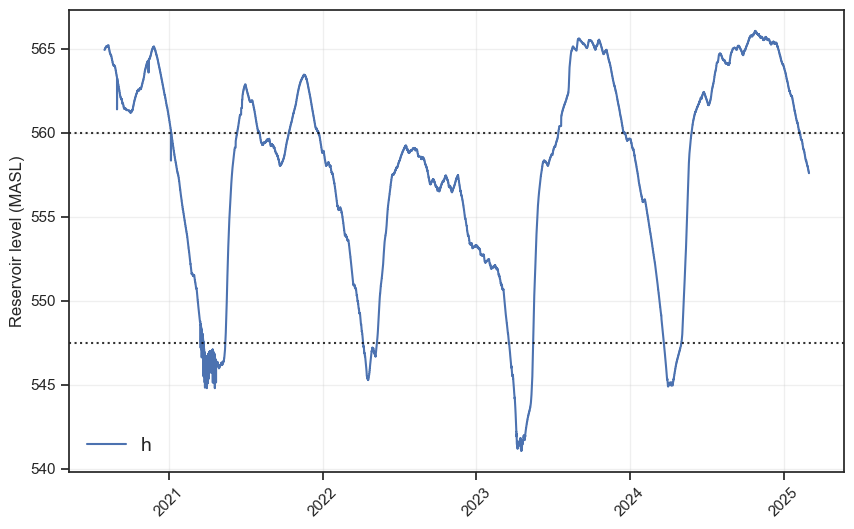

In [106]:
# Plotting all water levels data (GW pipes + ÖVY reservoir water level)
plt.clf()
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20b.colors

plt.plot(dates, X_all['h'], label='h')
plt.axhline(y=547.5, color='black', alpha=0.8, linestyle=':')
plt.axhline(y=560, color='black', alpha=0.8, linestyle=':')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Reservoir level (MASL)')
plt.legend(loc='lower left', fontsize=14)
plt.grid(True, alpha=0.3)

plt.show()

In [185]:
def plot_timeseries_with_highlight(dates, data, target_column, yearly_dates, 
                                   highlight_type='month', 
                                   periods_to_highlight=None, period_colors=None,
                                   figsize=(10, 6), alpha=0.2, line_color=None,
                                   ylabel='Value', title=None, grid=True,
                                   legend_loc='lower left'):
    """
    Plot a time series with highlighted months or quarters.
    
    Parameters:
    -----------
    dates : pandas.Series
        Series of datetime values
    data : pandas.DataFrame
        DataFrame containing the data to plot
    target_column : str
        Column name in data to plot
    yearly_dates : dict
        Dictionary with years as keys and datetime arrays as values
    highlight_type : str, optional
        'month' or 'quarter' to specify the type of period to highlight
    periods_to_highlight : int or list, optional
        If int: Single period to highlight
        If list: Multiple periods to highlight with colors from period_colors
        For months: 1-12
        For quarters: 1-4
    period_colors : list, optional
        List of colors to use for the periods. If None, default colors will be used.
    figsize : tuple, optional
        Figure size (width, height)
    alpha : float, optional
        Transparency of shaded regions
    line_color : str, optional
        Color of the main line plot
    ylabel : str, optional
        Y-axis label
    title : str, optional
        Plot title
    grid : bool, optional
        Whether to show grid
    legend_loc : str, optional
        Location of the legend
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.patches as mpatches
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the main data
    line_kwargs = {'linewidth': 2}
    if line_color:
        line_kwargs['color'] = line_color
    
    line = ax.plot(dates, data[target_column], label=target_column, **line_kwargs)[0]
    
    # Define quarter to month mapping
    quarter_to_months = {
        1: [1, 2, 3],
        2: [4, 5, 6],
        3: [7, 8, 9],
        4: [10, 11, 12]
    }
    
    # Process periods_to_highlight parameter
    if periods_to_highlight is None:
        # No highlighting requested
        periods_list = []
    elif isinstance(periods_to_highlight, int):
        # Single period as integer
        periods_list = [periods_to_highlight]
        if period_colors is None:
            period_colors = ['gray']
    elif isinstance(periods_to_highlight, list):
        # List of periods
        periods_list = periods_to_highlight
        if period_colors is None:
            # Generate colors if not provided
            cmap = plt.cm.tab10
            period_colors = [cmap(i % 10) for i in range(len(periods_list))]
    else:
        raise ValueError("periods_to_highlight must be an int or list")
    
    # Make sure period_colors is at least as long as periods_list
    if len(period_colors) < len(periods_list):
        cmap = plt.cm.tab10
        period_colors.extend([cmap(i % 10) for i in range(len(period_colors), len(periods_list))])
    
    # Create patches for legend
    legend_patches = [line]
    legend_labels = [target_column]
    
    # Highlight periods
    if periods_to_highlight is not None:
        for i, period in enumerate(periods_list):
            color = period_colors[i]
            
            # Determine months to include based on highlight type
            if highlight_type.lower() == 'month':
                months_to_include = [period]
                period_label = f'Month {period:02d}'
            elif highlight_type.lower() == 'quarter':
                if period < 1 or period > 4:
                    raise ValueError("Quarter must be between 1 and 4")
                months_to_include = quarter_to_months[period]
                period_label = f'Q{period}'
            else:
                raise ValueError("highlight_type must be 'month' or 'quarter'")
            
            # Add to legend
            legend_patches.append(mpatches.Patch(color=color, alpha=alpha))
            legend_labels.append(period_label)
            
            # Process each year
            for year, year_dates_array in yearly_dates.items():
                # Convert to pandas datetime if needed
                if not isinstance(year_dates_array, pd.DatetimeIndex):
                    year_dates = pd.DatetimeIndex(year_dates_array)
                else:
                    year_dates = year_dates_array
                
                if highlight_type.lower() == 'month':
                    # For months, process each month individually
                    for month in months_to_include:
                        # Find all dates in this year that match the target month
                        month_dates = year_dates[year_dates.month == month]
                        
                        # Only create a span if we have dates for this month in this year
                        if len(month_dates) > 0:
                            # Get the first and last date for this month
                            start_date = month_dates[0]
                            end_date = month_dates[-1]
                            
                            # Create a single span for the whole month
                            ax.axvspan(start_date, end_date, alpha=alpha, color=color)
                
                elif highlight_type.lower() == 'quarter':
                    # For quarters, find the first month and last month to create one continuous span
                    quarter_dates = year_dates[year_dates.month.isin(months_to_include)]
                    
                    if len(quarter_dates) > 0:
                        # Get the first and last date for this quarter
                        start_date = quarter_dates[0]
                        end_date = quarter_dates[-1]
                        
                        # Create a single span for the whole quarter
                        ax.axvspan(start_date, end_date, alpha=alpha, color=color)
    
    # Set labels and style
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel(ylabel)
    
    if title:
        ax.set_title(title)
    
    # Add the legend with our custom handles and labels
    ax.legend(handles=legend_patches, labels=legend_labels, loc=legend_loc, fontsize=12)
    
    if grid:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

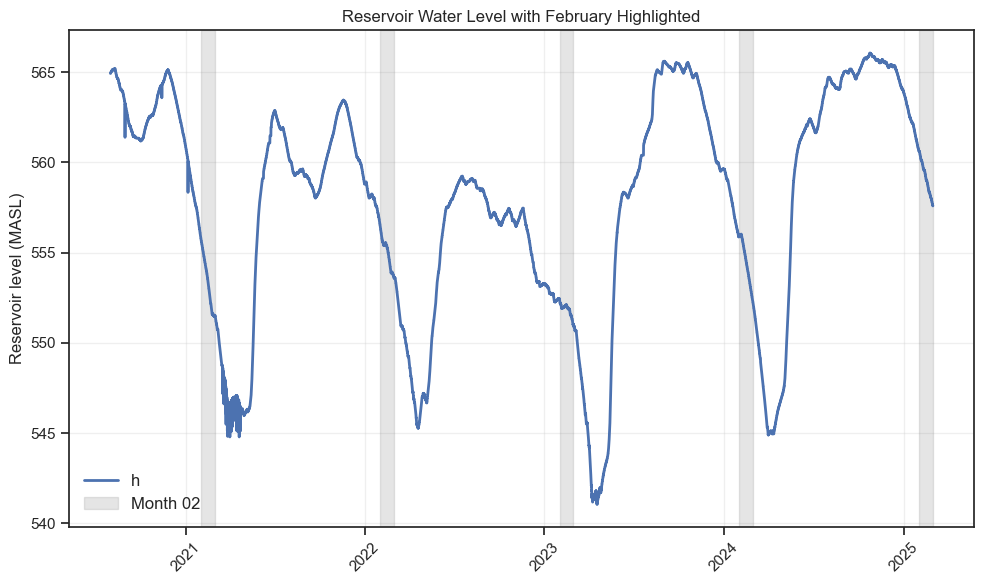

In [186]:
# Example 1: Highlight a single month
fig, ax = plot_timeseries_with_highlight(
    dates=dates,
    data=X_all,
    target_column='h',
    yearly_dates=yearly_dates,
    periods_to_highlight=2,  # February
    ylabel='Reservoir level (MASL)',
    title='Reservoir Water Level with February Highlighted'
)
plt.show()

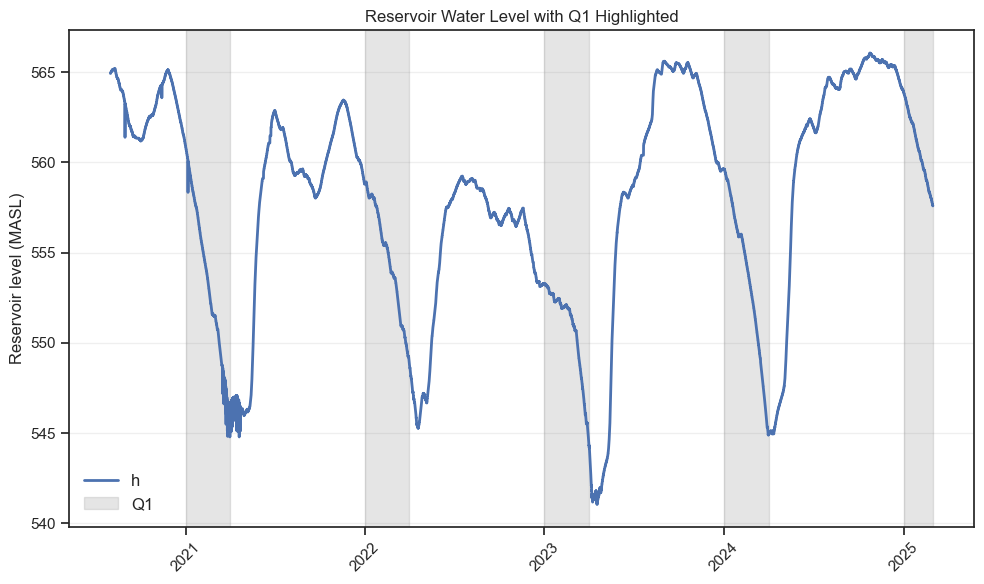

In [187]:
# Example 2: Highlight a single quarter
fig, ax = plot_timeseries_with_highlight(
    dates=dates,
    data=X_all,
    target_column='h',
    yearly_dates=yearly_dates,
    highlight_type='quarter',
    periods_to_highlight=1,  # Q1 (Jan-Mar)
    ylabel='Reservoir level (MASL)',
    title='Reservoir Water Level with Q1 Highlighted'
)
plt.show()

In [227]:
print("Feature names:")
print(LGBM_model.feature_name_)

Feature names:
['Sin_s', 'Cos_s', 'Sin_2s', 'Cos_2s', 't', 'ln_t', 'month', 'year', 'GV1', 'GV3', 'MB4', 'MB8', 'MB10', 'MB18', 'h', 'h_MA_007', 'h_MA_014', 'h_MA_030', 'h_MA_060', 'h_RC_007', 'h_RC_030', 'P', 'P_RS_007', 'P_RS_030', 'P_RS_060', 'P_RS_090', 'P_RS_180', 'TA', 'TA_MA_001', 'TA_MA_007', 'TA_MA_030', 'TA_MA_060', 'TW', 'TW_MA_007', 'TW_MA_030', 'Q', 'Q_RS_007', 'Q_RS_030']


In [413]:
%%time
explainer = shap.TreeExplainer(LGBM_model)

CPU times: total: 78.1 ms
Wall time: 332 ms


In [447]:
shap_explainer_test =  explainer(X_test)

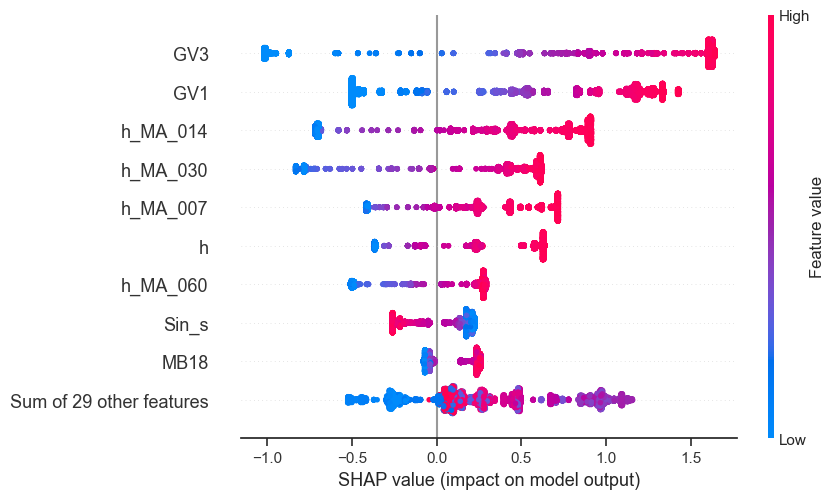

In [448]:
shap.plots.beeswarm(shap_explainer_test)

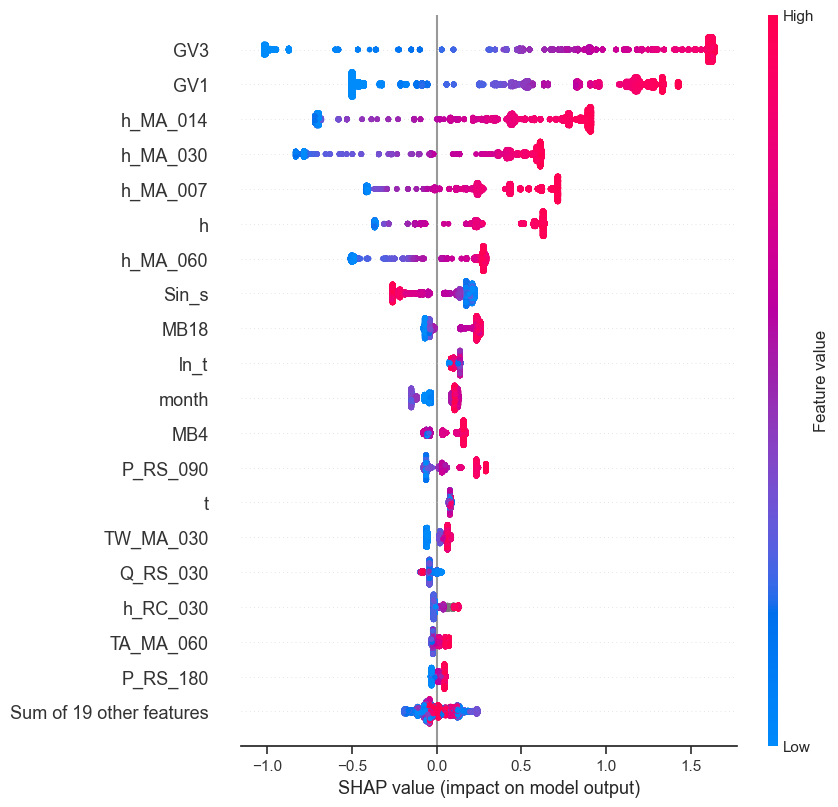

In [449]:
shap.plots.beeswarm(shap_explainer_test, max_display=20)

In [457]:
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

In [502]:
from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

In [ ]:
def grouped_shap_mean(shap_vals, features, groups):
    groupmap = revert_dict(groups) 
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    # print(shap_Tdf)  # Control so that all features grouped matches the df!
    shap_grouped = shap_Tdf.groupby('group').mean().T
    return shap_grouped

def grouped_shap_pos_neg(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    
    # Create DataFrame with features as columns and samples as rows
    shap_df = pd.DataFrame(shap_vals, columns=features)
    
    # Transpose to get features as rows
    shap_Tdf = shap_df.T
    
    # Add group mapping
    shap_Tdf['group'] = shap_Tdf.index.map(groupmap)
    
    # Store the group column
    group_col = shap_Tdf['group'].copy()
    
    # Remove the group column before numerical operations
    shap_Tdf = shap_Tdf.drop(columns=['group'])
    
    # Create positive-only and negative-only DataFrames
    pos_df = shap_Tdf.copy()
    pos_df = pos_df.mask(pos_df < 0, 0)  # Replace negative values with 0
    
    neg_df = shap_Tdf.copy()
    neg_df = neg_df.mask(neg_df > 0, 0)  # Replace positive values with 0
    
    # Add group column back
    pos_df['group'] = group_col
    neg_df['group'] = group_col
    
    # Calculate means
    shap_pos = pos_df.groupby('group').mean().T
    shap_neg = neg_df.groupby('group').mean().T
    
    return shap_pos, shap_neg

def grouped_shap_sum(shap_vals, features, groups):
    groupmap = revert_dict(groups) 
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    # print(shap_Tdf)  # Control so that all features grouped matches the df!
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

def grouped_features_normalized_mean(values, features, groups):     
    groupmap = revert_dict(groups)     
    values_normalized = (values - values.min()) / (values.max() - values.min())
    val_Tdf = pd.DataFrame(values_normalized, columns=pd.Index(features, name='features')).T     
    val_Tdf['group'] = val_Tdf.reset_index().features.map(groupmap).values     
    val_grouped = val_Tdf.groupby('group').mean().T     
    return val_grouped

In [479]:
def grouped_shap_pos_neg_with_features(shap_vals, feature_vals, features, groups):
    groupmap = revert_dict(groups)
    
    # Normalize feature values
    feature_vals_normalized = (feature_vals - feature_vals.min()) / (feature_vals.max() - feature_vals.min())
    
    # Create SHAP DataFrame and add group mapping
    shap_df = pd.DataFrame(shap_vals, columns=features).T
    shap_df['group'] = shap_df.index.map(groupmap)
    
    # Store the group column
    group_col = shap_df['group'].copy()
    
    # Remove the group column before numerical operations
    shap_df_numeric = shap_df.drop(columns=['group'])
    
    # Create positive-only and negative-only DataFrames
    pos_df = shap_df_numeric.copy()
    pos_df = pos_df.mask(pos_df < 0, 0)  # Replace negative values with 0
    
    neg_df = shap_df_numeric.copy()
    neg_df = neg_df.mask(neg_df > 0, 0)  # Replace positive values with 0
    
    # Add group column back
    pos_df['group'] = group_col
    neg_df['group'] = group_col
    
    # Calculate means for SHAP values
    shap_pos = pos_df.groupby('group').mean().T
    shap_neg = neg_df.groupby('group').mean().T
    
    # Process feature values with the same grouping
    val_df = pd.DataFrame(feature_vals_normalized, columns=features).T
    val_df['group'] = val_df.index.map(groupmap)
    val_grouped = val_df.groupby('group').mean().T
    
    return shap_pos, shap_neg, val_grouped

In [432]:
all_features_grouped = {
    'Reservoir level': ['h',
              'h_MA_007',
              'h_MA_014',
              'h_MA_030',
              'h_MA_060'],
    'Reservoir rate of change': ['h_RC_007',
               'h_RC_030'],
    'Precipitation': ['P',
          'P_RS_007',
          'P_RS_030',
          'P_RS_060',
          'P_RS_090',
          'P_RS_180'],
    'Air Temperature': ['TA',
           'TA_MA_001',
           'TA_MA_007',
           'TA_MA_014',
           'TA_MA_030',
           'TA_MA_060'],
    'Water Temperature': ['TW',
           'TW_MA_007',
           'TW_MA_030'],
    'Local Inflow': ['Q',
          'Q_RS_007',
          'Q_RS_030'],
    'Trigonometric functions': ['Sin_s',
                 'Cos_s',
                 'Sin_2s',
                 'Cos_2s'],
    'Time-related features': ['t',
             'ln_t',
             'month',
             'year'],
    'GV1': ['GV1'], 
    'GV3': ['GV3'], 
    'MB4': ['MB4'], 
    'MB8': ['MB8'], 
    'MB10': ['MB10'],
    'MB18': ['MB18']
}

In [417]:
map_all_grouped = revert_dict(all_features_grouped)
print(map_all_grouped)

{'h': 'Reservoir level', 'h_MA_007': 'Reservoir level', 'h_MA_014': 'Reservoir level', 'h_MA_030': 'Reservoir level', 'h_MA_060': 'Reservoir level', 'h_RC_007': 'Reservoir rate of change', 'h_RC_030': 'Reservoir rate of change', 'P': 'Precipitation', 'P_RS_007': 'Precipitation', 'P_RS_030': 'Precipitation', 'P_RS_060': 'Precipitation', 'P_RS_090': 'Precipitation', 'P_RS_180': 'Precipitation', 'TA': 'Air Temperature', 'TA_MA_001': 'Air Temperature', 'TA_MA_007': 'Air Temperature', 'TA_MA_014': 'Air Temperature', 'TA_MA_030': 'Air Temperature', 'TA_MA_060': 'Air Temperature', 'TW': 'Water Temperature', 'TW_MA_007': 'Water Temperature', 'TW_MA_030': 'Water Temperature', 'Q': 'Local Inflow', 'Q_RS_007': 'Local Inflow', 'Q_RS_030': 'Local Inflow', 'Sin_s': 'Harmonic functions', 'Cos_s': 'Harmonic functions', 'Sin_2s': 'Harmonic functions', 'Cos_2s': 'Harmonic functions', 't': 'Time-related features', 'ln_t': 'Time-related features', 'month': 'Time-related features', 'year': 'Time-related fe

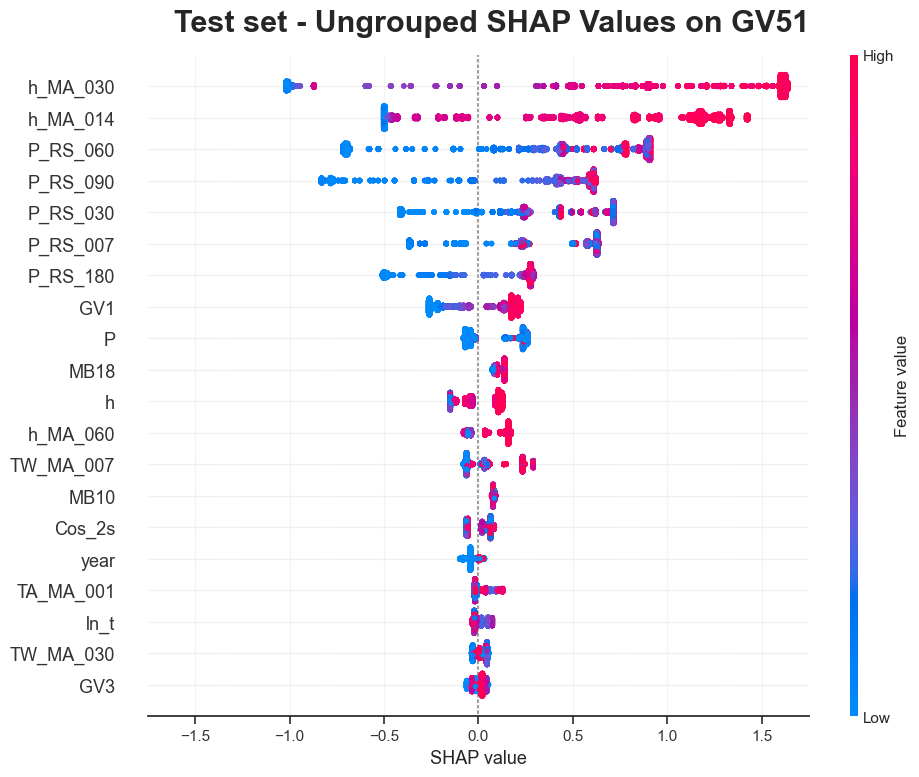

In [455]:
shap.summary_plot(shap_values_test, X_test[features], show = False)
plt.gcf().suptitle(f'Test set - Ungrouped SHAP Values on {target}', fontsize=22, fontweight='bold', y=0.97)
plt.gcf().set_size_inches(10,8)

plt.tight_layout()  # Leaves space at the top for the title
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.xlim(-1.75, 1.75)
plt.xlabel("SHAP value")
plt.show()

In [505]:
print(shap_values_test)

[[-0.25818495 -0.03471441 -0.00131718 ... -0.01138062  0.00346249
   0.03012569]
 [-0.25818495 -0.03460384 -0.00131718 ... -0.01138062  0.00346249
   0.03012569]
 [-0.25818495 -0.03471441 -0.00131718 ... -0.01138062  0.00346249
   0.03012569]
 ...
 [-0.21599752  0.02453492  0.00618056 ...  0.00059708 -0.00444127
   0.02751708]
 [-0.21599752  0.02453492  0.00618056 ...  0.00059708 -0.00444127
   0.02751708]
 [-0.22932531  0.02453492  0.00618056 ...  0.00059708 -0.00444127
   0.02751708]]


In [506]:
print(X_test)

          Sin_s     Cos_s    Sin_2s    Cos_2s     t      ln_t  month  year  \
32122  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32123  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32124  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32125  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
32126  0.999991  0.004304  0.008607 -0.999963  1339  7.199678      3  2024   
...         ...       ...       ...       ...   ...       ...    ...   ...   
40148  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40149  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40150  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40151  0.849817  0.527078  0.895839 -0.444378  1673  7.422374      2  2025   
40152  0.858764  0.512371  0.880012 -0.474951  1674  7.422971      3  2025   

          GV1     GV3  ...  TA_MA_001  TA_MA_007  TA_MA_030  TA

In [487]:
val_grouped = grouped_features_normalized_mean(X_test, features, all_features_grouped)
shap_grouped = grouped_shap_mean(shap_values_test, features, all_features_grouped)

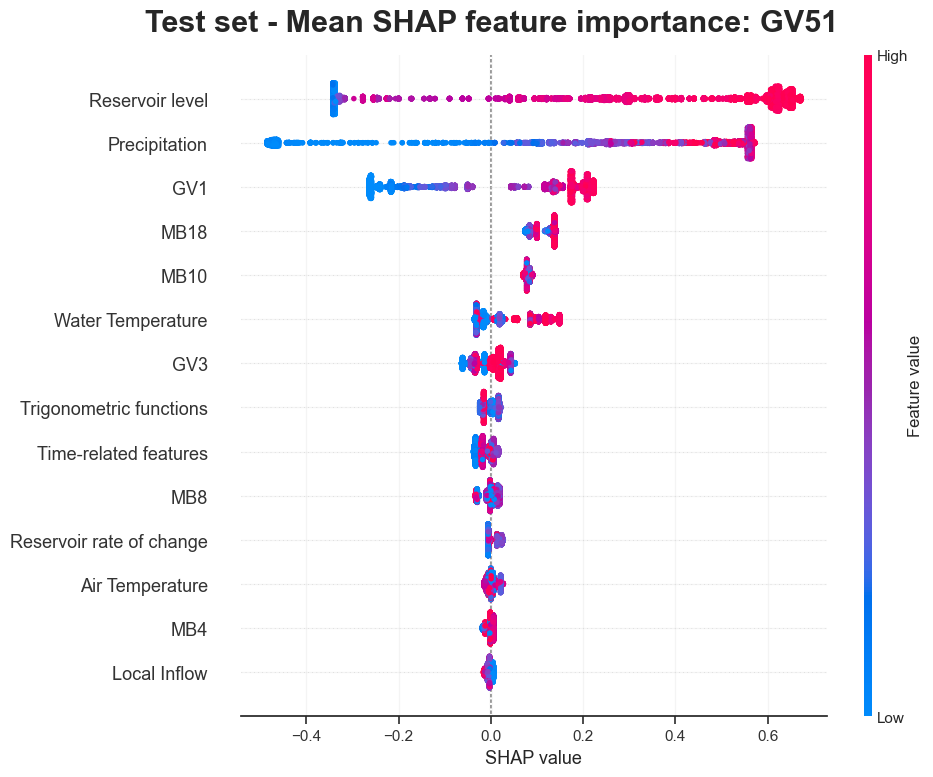

In [472]:
# Create the plot
shap.summary_plot(shap_grouped.values, val_grouped.values, feature_names=shap_grouped.columns, show = False)

plt.gcf().suptitle(f'Test set - Mean SHAP feature importance: {target}', fontsize=22, fontweight='bold', y=0.97)
plt.gcf().set_size_inches(10,8)
# plt.xlim(-0.7, 0.7)

plt.tight_layout()
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.xlabel("SHAP value")
plt.show()

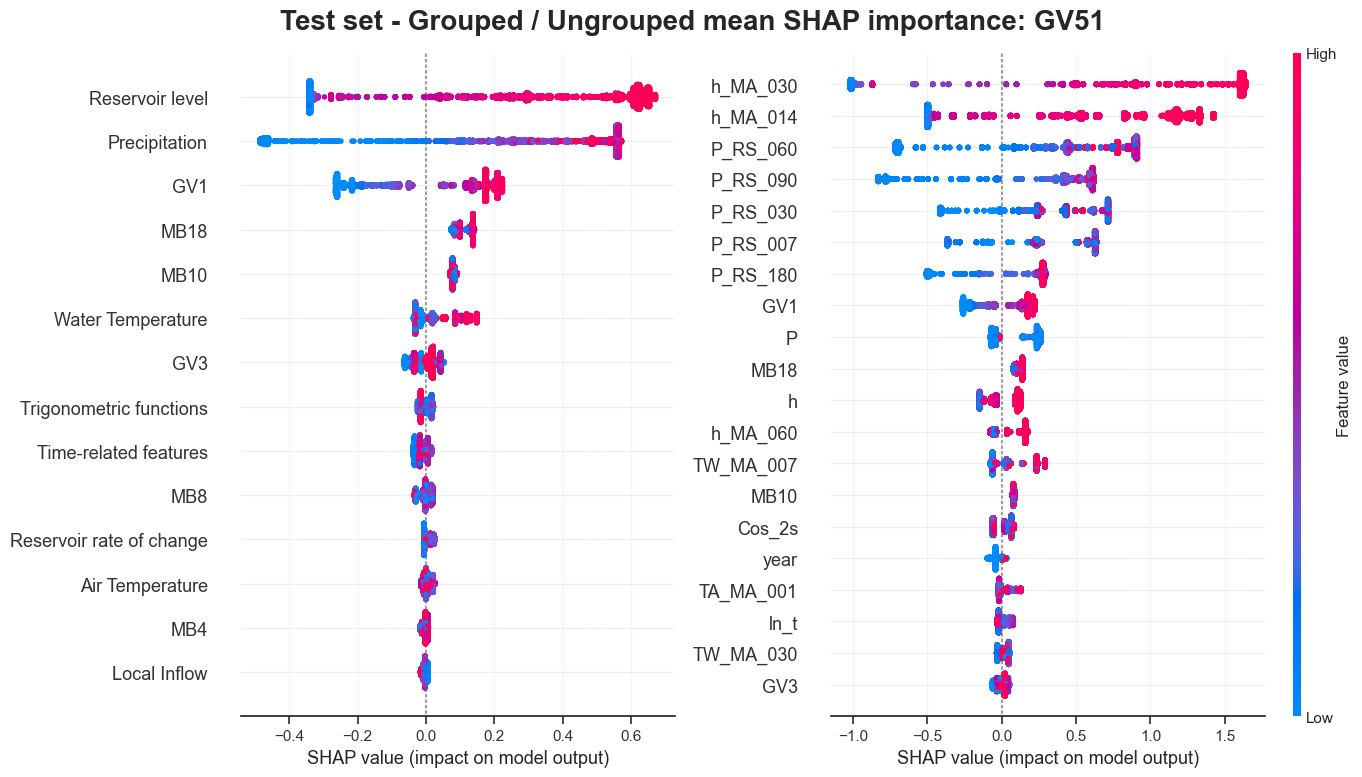

In [501]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First plot (without legend)
plt.sca(ax1)  # Set current axis
shap_obj = shap.summary_plot(
    shap_grouped.values, 
    val_grouped.values, 
    feature_names=shap_grouped.columns,
    show=False,
    plot_size=(16, 8)  # This helps control the size within the subplot
)

plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)

# Find and remove the colorbar from the first plot
for cbar in fig.axes:
    if cbar != ax1 and cbar != ax2:
        cbar.remove()

# Second plot (with legend)
plt.sca(ax2)  # Set current axis
shap.summary_plot(
    shap_values_test, 
    X_test[features], 
    show=False,
    plot_size=(14, 8)
)

plt.gcf().suptitle(f'Test set - Grouped / Ungrouped mean SHAP importance: {target}', fontsize=20, fontweight='bold', y=0.97)
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.tight_layout()
plt.show()

In [484]:
# Get positive SHAP, negative SHAP, and normalized feature values
shap_pos, shap_neg, val_grouped = grouped_shap_pos_neg_with_features(
    shap_values_test, 
    X_test.values,  # Assuming X_test is your feature matrix
    features, 
    all_features_grouped
)

c:\Users\xkorpijo3\AppData\Local\miniconda3\envs\test_env\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


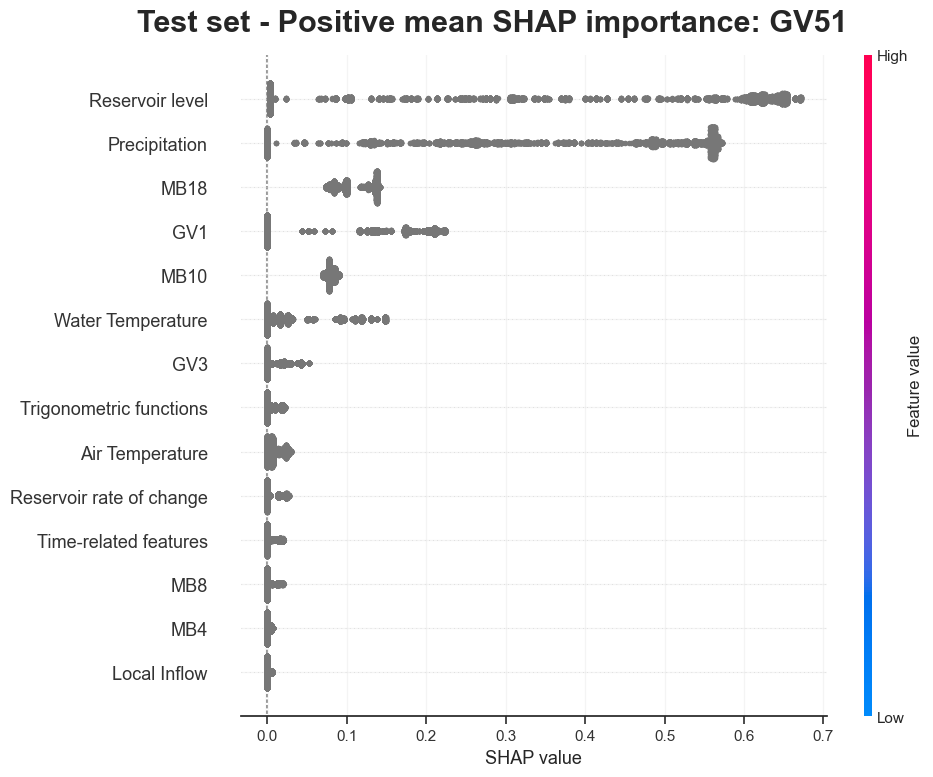

In [485]:
# Create the plot
shap.summary_plot(shap_pos.values, val_grouped.values, feature_names=shap_grouped.columns, show = False)

plt.gcf().suptitle(f'Test set - Positive mean SHAP importance: {target}', fontsize=22, fontweight='bold', y=0.97)
plt.gcf().set_size_inches(10,8)
# plt.xlim(-0.7, 0.7)

plt.tight_layout()
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.xlabel("SHAP value")
plt.show()

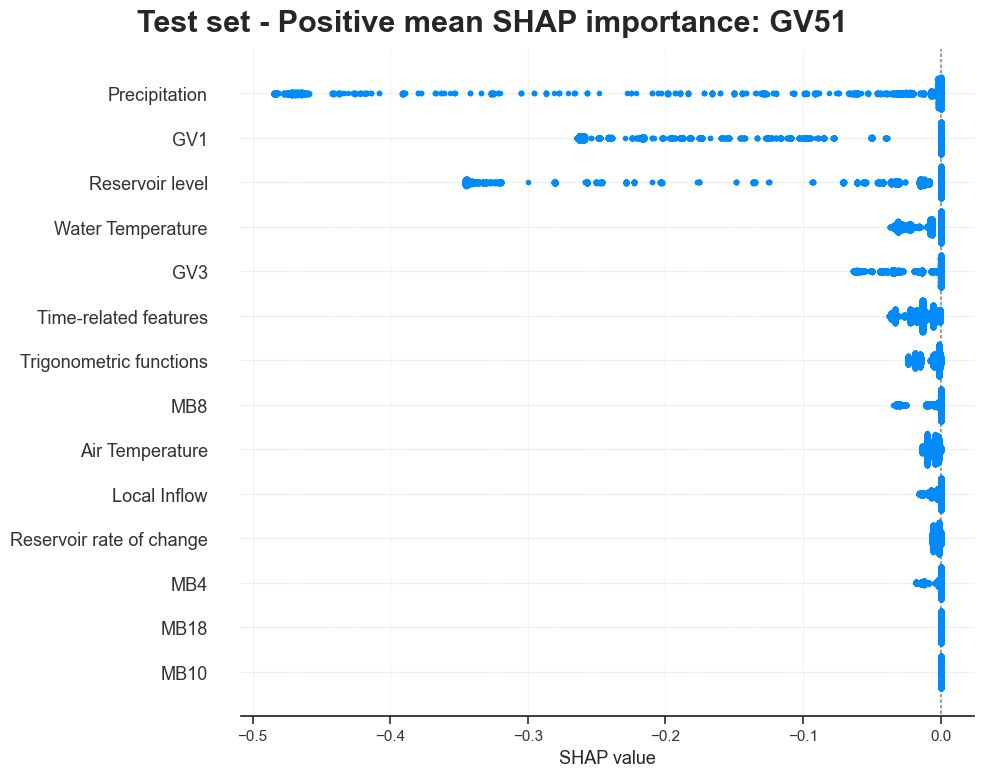

In [478]:
# Create the plot
shap.summary_plot(shap_grouped_neg.values, feature_names=shap_grouped.columns, show = False)

plt.gcf().suptitle(f'Test set - Positive mean SHAP importance: {target}', fontsize=22, fontweight='bold', y=0.97)
plt.gcf().set_size_inches(10,8)
# plt.xlim(-0.7, 0.7)

plt.tight_layout()
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.xlabel("SHAP value")
plt.show()